## Exploration and Exploitation

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from bandit import Bandit, EpsGreedyPolicy, SoftmaxPolicy, IntervalPolicy

### Multi-armed bandit problems

In [2]:
theta = np.linspace(0.1, 0.9, 5)
bandit = Bandit(theta)

epsGreedyPolicy = EpsGreedyPolicy(0.2)
softmaxPolicy = SoftmaxPolicy(10)
intervalPolicy = IntervalPolicy(0.9)

In [3]:
max_iter = 100
steps = 50

epsGreedyResults = np.zeros(steps)
softmaxResults = np.zeros(steps)
intervalResults = np.zeros(steps)

for iter in range(max_iter):
    bandit.reset()
    epsGreedyResults += bandit.simulate(policy=epsGreedyPolicy, steps=steps)
    
    bandit.reset()
    softmaxResults += bandit.simulate(policy=softmaxPolicy, steps=steps)
    
    bandit.reset()
    intervalResults += bandit.simulate(policy=intervalPolicy, steps=steps)

epsGreedyResults = epsGreedyResults / np.arange(1, steps+1) / max_iter
softmaxResults = softmaxResults / np.arange(1, steps+1) / max_iter
intervalResults = intervalResults / np.arange(1, steps+1) / max_iter

df = pd.DataFrame()
df['epsGreedy'] = epsGreedyResults
df['softMax'] = softmaxResults
df['interval'] = intervalResults
# df.to_csv('bandit.csv', index=False)

In [4]:
import matplotlib.pylab as plt

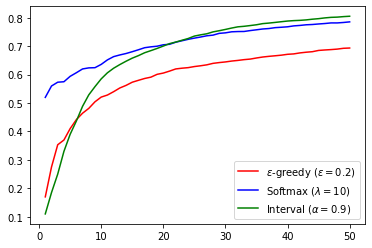

In [5]:
x = np.arange(1, steps+1)
plt.plot(x, epsGreedyResults, 'r', x, softmaxResults, 'b', x, intervalResults, 'g')
plt.legend(['$\epsilon$-greedy ($\epsilon=0.2$)', 'Softmax ($\lambda=10$)', 'Interval ($\\alpha=0.9$)'])

## Model-Based Reinforcement Learning

In [6]:
from mdpagent import MDP, ModelRLAgent
from environment import GridWorld5x5, GridWorld10x10, GridWorld3x4

In [7]:
actions = ['left', 'up', 'right', 'down']
# env = GridWorld5x5(actions)
# env = GridWorld10x10(actions)
env = GridWorld3x4(actions)

In [8]:
model = MDP(env.n_states, env.n_actions)
model.reset()

mrlAgent = ModelRLAgent(env.n_states, env.n_actions, env.action_sets, epsilon=0.2)
mrlAgent.run_episodes(env, model, n_episodes=2000, n_steps=1000)

100%|██████████| 2000/2000 [00:01<00:00, 1243.52it/s]


In [9]:
df = env.show_state_value(mrlAgent.U)
df

,0,1,2,3
0,0.648841,0.750001,0.854420,1.000000
1,0.569829,0.000000,0.615377,-1.000000
2,0.495062,0.444919,0.507880,0.280798


In [10]:
mrlAgent.extract_policy()
df = env.show_policy(mrlAgent.pi)
df

,0,1,2,3
0,right,right,right,left
1,up,left,up,left
2,up,right,up,left


## Monte Carlo Policy Iteration

In [11]:
from environment import RandomWalk
from mdpagent import MonteCarloRLAgent

actions = ['left', 'right']
env = RandomWalk(actions)

In [12]:
mcAgent = MonteCarloRLAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.2, alpha=0.1)

pi = np.ones((env.n_states, env.n_actions)) / env.n_actions
mcAgent.iterative_policy_evaluation(1000, 100, env, pi, method='every-visit')
env.show_state_value(mcAgent.U)

100%|██████████| 1000/1000 [00:00<00:00, 7474.12it/s]


,0,1,2,3,4
0,0.167728,0.330841,0.495296,0.655863,0.83218


In [13]:
mcAgent.reset()
mcAgent.policy_iteration(1000, 100, env, method='first-visit')
env.show_state_value(mcAgent.U)

100%|██████████| 1000/1000 [00:00<00:00, 9260.11it/s]


,0,1,2,3,4
0,0.857143,0.980952,0.99384,0.998968,1.0


## Temporal Difference Learning

In [14]:
from mdpagent import TDLearningAgent

In [15]:
actions = ['left', 'right']
env = RandomWalk(actions)

pi = np.ones((env.n_states, env.n_actions)) / env.n_actions

In [16]:
tdlAgent = TDLearningAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.2, alpha=0.1, verbose=True)
tdlAgent.U = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0])
values = tdlAgent.iterative_policy_evaluation(1000, 100, env, pi)
env.show_state_value(tdlAgent.U)

100%|██████████| 1000/1000 [00:00<00:00, 10782.27it/s]


,0,1,2,3,4
0,0.238678,0.424768,0.585027,0.73745,0.860669


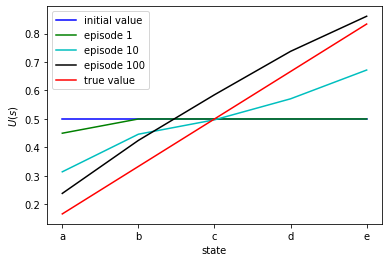

In [17]:
dim = env.n_nonterminal_states
x = np.arange(dim)

df = pd.DataFrame()
df['state'] = range(1, 6)
df['t0'] = [0.5, 0.5, 0.5, 0.5, 0.5]
df['t1'] = values[0][0:dim]
df['t10'] = values[9][0:dim]
df['t100'] = values[-1][0:dim]
df['true_value'] = [1/6, 2/6, 3/6, 4/6, 5/6]
# df.to_csv('random_walk.csv', index=False)

plt.plot(x, [0.5, 0.5, 0.5, 0.5, 0.5], color='b', label='initial value')
plt.plot(x, values[0][0:dim], color='g', label='episode 1')
plt.plot(x, values[9][0:dim], color='c', label='episode 10')
plt.plot(x, values[-1][0:dim], color='k', label='episode 100')
plt.plot(x, [1/6, 2/6, 3/6, 4/6, 5/6], color='r', label='true value')

plt.xticks(x, (['a', 'b', 'c', 'd', 'e']))
plt.xlabel('state')
plt.ylabel('$U(s)$')
plt.legend()

In [18]:
from tqdm import tqdm

def rms_error():
    actions = np.array(['left', 'right'])
    env = RandomWalk(actions)
    true_values = np.array([1/6, 2/6, 3/6, 4/6, 5/6, 0])

    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]

    n_episodes = 100
    n_runs = 100

    pi = np.ones((env.n_states, env.n_actions)) / env.n_actions

    df = pd.DataFrame()

    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(n_episodes)

        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'

        for _ in tqdm(range(n_runs)):
            if method == 'TD':
                tdlAgent = TDLearningAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.2, alpha=alpha, verbose=True)
                tdlAgent.U = [0.5, 0.5, 0.5, 0.5, 0.5, 0]
                values = tdlAgent.iterative_policy_evaluation(n_episodes, 100, env, pi, disable_bar=True)
            else:
                mcAgent = MonteCarloRLAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.2, alpha=alpha, verbose=True)
                mcAgent.U = [0.5, 0.5, 0.5, 0.5, 0.5, 0]
                values = mcAgent.td_learning(n_episodes, 100, env, pi, disable_bar=True)

            total_errors += np.sqrt(np.sum(np.power(values - true_values, 2) / 5, axis=1))
        
        total_errors /= n_runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))

        df['%s%.2f' %(method, alpha)] = total_errors.copy()
    
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

    return df

100%|██████████| 100/100 [00:02<00:00, 41.03it/s]


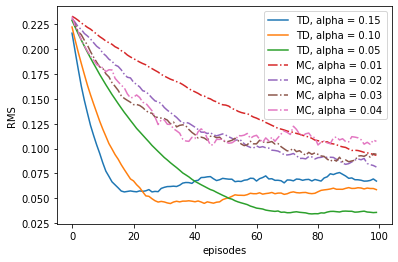

In [19]:
df = rms_error()
# df.to_csv('random_walk_mc_td.csv', index=False)

## SARSA, Q-Learning


In [20]:
from environment import CliffWalking

actions = ['left', 'up', 'right', 'down']
env = CliffWalking(actions)

In [21]:
tdlAgent = TDLearningAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.1, alpha=0.5)

### Sarsa

In [22]:
tdlAgent.reset()
_ = tdlAgent.sarsa(500, 1000, env)

100%|██████████| 500/500 [00:00<00:00, 1941.41it/s]


In [23]:
tdlAgent.state_value()
env.show_state_value(tdlAgent.U)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-15.331652,-14.451915,-14.185977,-13.442027,-12.811888,-12.468665,-9.799280,-8.171249,-6.797059,-5.286929,-4.088932,-3.012173
1,-16.847056,-16.334907,-15.740891,-15.828294,-13.281086,-11.456029,-11.284850,-8.006839,-7.398256,-6.818308,-3.263008,-2.000008
2,-18.310672,-19.238543,-19.624769,-17.954472,-15.506734,-14.268097,-15.088971,-15.705492,-9.438901,-6.003609,-2.935926,-1.000000
3,-19.610132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
tdlAgent.extract_policy()
env.show_policy(tdlAgent.pi)

,0,1,2,3,4,5,6,7,8,9,10,11
0,right,right,right,right,right,down,right,right,right,right,right,down
1,up,up,up,up,right,right,up,right,right,up,right,down
2,up,up,up,right,up,up,up,left,up,up,right,down
3,up,left,left,left,left,left,left,left,left,left,left,left


### Q-learning

In [25]:
tdlAgent.reset()
_ = tdlAgent.q_learning(500, 1000, env)

100%|██████████| 500/500 [00:00<00:00, 1778.52it/s]


In [26]:
tdlAgent.state_value()
env.show_state_value(tdlAgent.U)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-12.473266,-11.745518,-10.954336,-10.118957,-9.282304,-8.415075,-7.576770,-6.719518,-5.781053,-4.904206,-3.964531,-2.997913
1,-12.941128,-11.991914,-10.998459,-9.999330,-8.999732,-7.999867,-6.999959,-5.999986,-4.999998,-4.000000,-3.000000,-2.000000
2,-12.000000,-11.000000,-10.000000,-9.000000,-8.000000,-7.000000,-6.000000,-5.000000,-4.000000,-3.000000,-2.000000,-1.000000
3,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
tdlAgent.extract_policy()
env.show_policy(tdlAgent.pi)

,0,1,2,3,4,5,6,7,8,9,10,11
0,right,right,down,right,right,right,right,right,down,right,right,down
1,right,down,right,down,right,right,down,right,down,right,down,down
2,right,right,right,right,right,right,right,right,right,right,right,down
3,up,left,left,left,left,left,left,left,left,left,left,left


In [28]:
def sarsa_vs_qlearning():
    actions = np.array(['left', 'up', 'right', 'down'])
    env = CliffWalking(actions)

    n_episodes = 500
    n_runs = 50

    rewards_sarsa = np.zeros(n_episodes)
    rewards_q_learning = np.zeros(n_episodes)

    tdlAgent = TDLearningAgent(env.n_states, env.n_actions, env.action_sets, discount=1, epsilon=0.1, alpha=0.5)

    df = pd.DataFrame()

    for _ in tqdm(range(n_runs)):
        tdlAgent.reset()
        rewards_sarsa += tdlAgent.sarsa(n_episodes, 10000, env, disable_bar=True)

        tdlAgent.reset()
        rewards_q_learning += tdlAgent.q_learning(n_episodes, 10000, env, disable_bar=True)

    rewards_sarsa /= n_runs
    rewards_q_learning /= n_runs

    df['sarsa'] = rewards_sarsa
    df['qlearning'] = rewards_q_learning

    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 0])
    plt.legend()

    return df

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


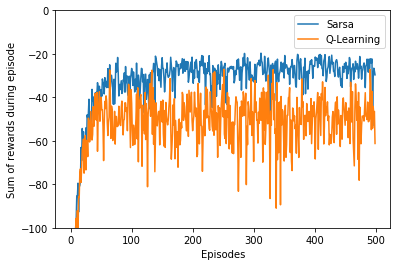

In [29]:
df = sarsa_vs_qlearning()
# df.to_csv('cliff_walk.csv', index=False)

## Value Function Approximation

### 1000-state random walk

In [30]:
from environment import RandomWalk1000

actions = ['left', 'right']
env = RandomWalk1000(actions)

In [31]:
from mdpagent import MDPAgent

pi = np.ones((env.n_states, env.n_actions)) / env.n_actions
mdpAgent = MDPAgent(env.n_states, env.n_actions, env.action_sets, discount=1, threshold=0.0001, max_iter=1000, verbose=True)
mdpAgent.iterative_policy_evaluation(env, pi)
true_values = mdpAgent.U[0 : env.n_nonterminal_states]

Iterative Policy Evaluation: iteration 1, delta 50.500000
Iterative Policy Evaluation: iteration 2, delta 33.582500
Iterative Policy Evaluation: iteration 3, delta 27.291463
Iterative Policy Evaluation: iteration 4, delta 23.510209
Iterative Policy Evaluation: iteration 5, delta 20.973638
Iterative Policy Evaluation: iteration 6, delta 19.110095
Iterative Policy Evaluation: iteration 7, delta 17.649758
Iterative Policy Evaluation: iteration 8, delta 16.434293
Iterative Policy Evaluation: iteration 9, delta 15.376968
Iterative Policy Evaluation: iteration 10, delta 14.428426
Iterative Policy Evaluation: iteration 11, delta 13.560505
Iterative Policy Evaluation: iteration 12, delta 12.756628
Iterative Policy Evaluation: iteration 13, delta 12.006648
Iterative Policy Evaluation: iteration 14, delta 11.303981
Iterative Policy Evaluation: iteration 15, delta 10.644044
Iterative Policy Evaluation: iteration 16, delta 10.023390
Iterative Policy Evaluation: iteration 17, delta 9.439243
Iterati

In [32]:
env.show_state_value(mdpAgent.U)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.92196,-0.920717,-0.919466,-0.918205,-0.916936,-0.915657,-0.91437,-0.913074,-0.911769,-0.910454,...,0.910454,0.911769,0.913074,0.91437,0.915657,0.916936,0.918205,0.919466,0.920717,0.92196


### Gradient Monte Carlo

In [33]:
from mdpagent import ApproximateRLAgent, AggregateValueFunction

In [34]:
aggregateValueFunction = AggregateValueFunction(10, env.n_nonterminal_states)
approximateRLAgent = ApproximateRLAgent(env.n_states, env.n_actions, aggregateValueFunction, env.action_sets, discount=1, alpha=2e-5)

approximateRLAgent.gradient_monte_carlo_policy_evaluation(100000, 1000, env, pi)
approximateRLAgent.approximate_state_value(env)
mc_values = approximateRLAgent.U[0 : env.n_nonterminal_states]
env.show_state_value(approximateRLAgent.U)

100%|██████████| 100000/100000 [06:18<00:00, 264.14it/s]


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,-0.823817,...,0.822756,0.822756,0.822756,0.822756,0.822756,0.822756,0.822756,0.822756,0.822756,0.822756


### Semi-gradient temporal difference

In [35]:
aggregateValueFunction = AggregateValueFunction(10, env.n_nonterminal_states)
approximateRLAgent = ApproximateRLAgent(env.n_states, env.n_actions, aggregateValueFunction, env.action_sets, discount=1, alpha=2e-4)

approximateRLAgent.semigradient_temporal_difference_policy_evaluation(100000, 1000, env, pi)
approximateRLAgent.approximate_state_value(env)
td_values = approximateRLAgent.U[0 : env.n_nonterminal_states]
env.show_state_value(approximateRLAgent.U)

100%|██████████| 100000/100000 [02:20<00:00, 709.63it/s]


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,-0.697591,...,0.724333,0.724333,0.724333,0.724333,0.724333,0.724333,0.724333,0.724333,0.724333,0.724333


In [36]:
df = pd.DataFrame()
df['state'] = range(1, env.n_nonterminal_states+1)
df['true_value'] = true_values
df['mc'] = mc_values
df['td'] = td_values
# df.to_csv('random_walk_1000.csv', index=False)

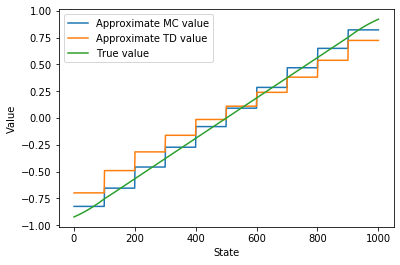

In [37]:
x = np.arange(1, env.n_nonterminal_states+1)
plt.plot(x, mc_values, label='Approximate MC value')
plt.plot(x, td_values, label='Approximate TD value')
plt.plot(x, true_values, label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

### Differential semi-gradient Sarsa

In [38]:
from environment import AccessControl
from mdpagent import TileCodingValueFunction

In [39]:
actions = ['reject', 'accept']
priorities = [1, 2, 4, 8]

env = AccessControl(actions, 10, priorities)

In [40]:
tileCoding = TileCodingValueFunction(8, 2048)
approximateRLAgent = ApproximateRLAgent(env.n_states, env.n_actions, tileCoding, env.action_sets, discount=1, epsilon=0.1, alpha=0.01, beta=0.01)
approximateRLAgent.differential_semigradient_sarsa(2000000, env)

100%|██████████| 2000000/2000000 [05:04<00:00, 6576.88it/s]


In [41]:
approximateRLAgent.average_reward

2.7905428769645124

In [42]:
approximateRLAgent.approximate_state_value(env)
df = env.show_state_value(approximateRLAgent.U)
df

,0,1,2,3,4,5,6,7,8,9,10
0,-9.441992,-5.795098,-3.266960,-1.264669,0.958702,2.144736,3.196473,4.324890,1.757585,0.320762,-0.000619
1,-8.626677,-5.681656,-3.156710,-1.322997,0.594110,2.571666,3.999843,5.050504,2.622608,0.543487,0.002398
2,-9.491304,-5.549946,-1.778232,0.180601,2.183925,4.213579,6.101564,7.194495,3.317010,0.745049,0.089744
3,-9.192500,-1.287967,2.158671,4.263027,6.767507,8.669565,9.975084,10.882335,5.815699,1.572325,0.130966


In [43]:
approximateRLAgent.approximate_action_value(env)
env.show_action_value(approximateRLAgent.Q)

,0,1,2,3,4,5,6,7,8,9,10
0,"{'reject': -9.44, 'accept': -1e+100}","{'reject': -5.8, 'accept': -7.93}","{'reject': -3.27, 'accept': -5.0}","{'reject': -1.26, 'accept': -2.25}","{'reject': 0.96, 'accept': -0.21}","{'reject': 2.14, 'accept': 1.44}","{'reject': 2.78, 'accept': 3.2}","{'reject': 0.95, 'accept': 4.32}","{'reject': -0.1, 'accept': 1.76}","{'reject': -0.06, 'accept': 0.32}","{'reject': -0.0, 'accept': -0.0}"
1,"{'reject': -8.63, 'accept': -1e+100}","{'reject': -5.68, 'accept': -7.41}","{'reject': -3.16, 'accept': -3.96}","{'reject': -1.32, 'accept': -1.55}","{'reject': 0.23, 'accept': 0.59}","{'reject': 2.27, 'accept': 2.57}","{'reject': 2.91, 'accept': 4.0}","{'reject': 0.89, 'accept': 5.05}","{'reject': 0.06, 'accept': 2.62}","{'reject': 0.01, 'accept': 0.54}","{'reject': -0.0, 'accept': 0.0}"
2,"{'reject': -9.49, 'accept': -1e+100}","{'reject': -5.87, 'accept': -5.55}","{'reject': -3.12, 'accept': -1.78}","{'reject': -1.38, 'accept': 0.18}","{'reject': 0.69, 'accept': 2.18}","{'reject': 2.03, 'accept': 4.21}","{'reject': 2.85, 'accept': 6.1}","{'reject': 1.21, 'accept': 7.19}","{'reject': 0.05, 'accept': 3.32}","{'reject': -0.03, 'accept': 0.75}","{'reject': -0.0, 'accept': 0.09}"
3,"{'reject': -9.19, 'accept': -1e+100}","{'reject': -5.55, 'accept': -1.29}","{'reject': -3.29, 'accept': 2.16}","{'reject': -1.54, 'accept': 4.26}","{'reject': 0.44, 'accept': 6.77}","{'reject': 2.11, 'accept': 8.67}","{'reject': 2.82, 'accept': 9.98}","{'reject': 1.21, 'accept': 10.88}","{'reject': 0.02, 'accept': 5.82}","{'reject': -0.04, 'accept': 1.57}","{'reject': -0.0, 'accept': 0.13}"


In [44]:
approximateRLAgent.extract_policy()
env.show_policy(approximateRLAgent.pi)

,0,1,2,3,4,5,6,7,8,9,10
0,reject,reject,reject,reject,reject,reject,accept,accept,accept,accept,accept
1,reject,reject,reject,reject,accept,accept,accept,accept,accept,accept,accept
2,reject,accept,accept,accept,accept,accept,accept,accept,accept,accept,accept
3,reject,accept,accept,accept,accept,accept,accept,accept,accept,accept,accept


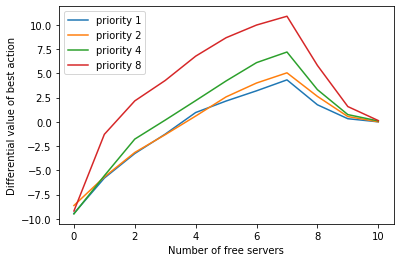

In [45]:
df_U = pd.DataFrame()
df_U['numofserver'] = range(env.n_servers+1)

for i, priority in enumerate(priorities):
    df_U['p%d' %priority] = df.iloc[i].values
    plt.plot(range(env.n_servers+1), df.iloc[i].values, label='priority %d' % priority)

# df_U.to_csv('queuing_value.csv', index=False)

plt.xlabel('Number of free servers')
plt.ylabel('Differential value of best action')
plt.legend()

## Monte Carlo Policy Gradient

In [46]:
from environment import ShortCorridor
from mdpagent import PolicyGradientAgent, Policy

In [47]:
actions = ['left', 'right']
env = ShortCorridor(actions)

theta = np.array([-1.47, 1.47])
beta = np.array([[0, 1], [1, 0]])

policy = Policy(theta, beta)

policyGradientAgent = PolicyGradientAgent(env.n_states, env.n_actions, policy, env.action_sets, discount=1, epsilon=0.05, alpha=2e-4, verbose=True)
_ = policyGradientAgent.reinforce(1000, 10000, env)
policyGradientAgent.policy.get_pi(env, policyGradientAgent.epsilon)

100%|██████████| 1000/1000 [00:01<00:00, 590.58it/s]


array([[0.36924649, 0.63075351],
       [0.36924649, 0.63075351],
       [0.36924649, 0.63075351],
       [0.36924649, 0.63075351]])

In [48]:
def policy_gradient():
    actions = ['left', 'right']
    env = ShortCorridor(actions)

    theta = np.array([-1.47, 1.47])
    beta = np.array([[0, 1], [1, 0]])

    n_runs = 100
    n_episodes = 1000
    alphas = [2e-4, 2e-5, 2e-3]

    rewards = np.zeros((len(alphas), n_runs, n_episodes))

    df = pd.DataFrame()

    for i, alpha in enumerate(alphas):
        for run in tqdm(range(n_runs)):
            policy = Policy(theta, beta)
            policyGradientAgent = PolicyGradientAgent(env.n_states, env.n_actions, policy, 
                                                            env.action_sets, discount=1, epsilon=0.05, 
                                                            alpha=alpha, verbose=True)
            rewards[i, run, :] = policyGradientAgent.reinforce(n_episodes, 10000, env, disable_bar=True)

    plt.plot(np.arange(n_episodes) + 1, -11.6 * np.ones(n_episodes), ls='dashed', color='red', label='-11.6')
    for i, alpha in enumerate(alphas):
        df['alpha%.5f' %alpha] = rewards[i].mean(axis=0)
        plt.plot(np.arange(n_episodes) + 1, rewards[i].mean(axis=0), label=alpha)

    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')

    return df

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


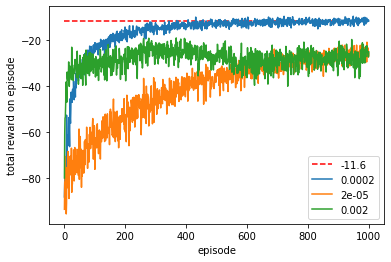

In [49]:
df = policy_gradient()
# df.to_csv('short_corridor.csv', index=False)